In [1]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import itertools
import yfinance as yf
import seaborn as sn
from IPython.core.display import display, HTML
from trend_following import (jupyter_interactive_mode, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices)
from strategy_performance_metrics import calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics, calculate_compounded_cumulative_returns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
jupyter_interactive_mode()

## Helper functions to help pull the data and run the analysis

## Pull the data from Yahoo Finance

We begin by pulling daily data for the specified instrument using the Yahoo finance API. The data available only goes back to late 2017. 

In [51]:
# Specify date range and pull data for specific instrument
start_date = pd.datetime(2014, 9, 17)
end_date = pd.datetime(2022, 12, 31)
# ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
ticker = 'BTC-USD'
data = load_financial_data(start_date, end_date, ticker)
data.columns = ['open', 'high', 'low', 'close', 'adjclose', 'volume']
data = get_returns_volatility(data, vol_range_list=[10, 20, 30, 60, 90], close_px_col='adjclose')

File data found...reading BTC-USD data


In [52]:
data.head()

,open,high,low,close,adjclose,volume,adjclose_pct_returns,adjclose_volatility_10,adjclose_volatility_20,adjclose_volatility_30,adjclose_volatility_60,adjclose_volatility_90
Date,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,-0.071926,NaN,NaN,NaN,NaN,NaN
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,-0.069843,NaN,NaN,NaN,NaN,NaN
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,0.035735,NaN,NaN,NaN,NaN,NaN
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,-0.024659,NaN,NaN,NaN,NaN,NaN


In [56]:
data[f'{ticker}_pct_returns'] = data[f'adjclose'].pct_change()

In [73]:
def weighted_avg(df, value_col, weight_col):
    return np.average(df[value_col], weights=df[weight_col])

In [96]:
data[f'{ticker}_volume_quantile'] = pd.qcut(data['volume'], q=15)
data[f'{ticker}_adjclose_volatility_10_quantile'] = pd.qcut(data['adjclose_volatility_10'], q=9)
data[f'{ticker}_adjclose_volatility_20_quantile'] = pd.qcut(data['adjclose_volatility_20'], q=9)
data[f'{ticker}_adjclose_volatility_30_quantile'] = pd.qcut(data['adjclose_volatility_30'], q=9)
data[f'{ticker}_adjclose_volatility_60_quantile'] = pd.qcut(data['adjclose_volatility_60'], q=9)
data[f'{ticker}_adjclose_volatility_90_quantile'] = pd.qcut(data['adjclose_volatility_90'], q=9)

In [97]:
data.head()

,open,high,low,close,adjclose,volume,adjclose_pct_returns,adjclose_volatility_10,adjclose_volatility_20,adjclose_volatility_30,adjclose_volatility_60,adjclose_volatility_90,BTC-USD_volume_quantile,BTC-USD_adjclose_volatility_10_quantile,BTC-USD_adjclose_volatility_20_quantile,BTC-USD_adjclose_volatility_30_quantile,BTC-USD_adjclose_volatility_60_quantile,BTC-USD_adjclose_volatility_90_quantile,BTC-USD_pct_returns
Date,,,,,,,,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,NaN,NaN,NaN,NaN,NaN,NaN,"(5914569.999, 21641960.0]",NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,-0.071926,NaN,NaN,NaN,NaN,NaN,"(21641960.0, 42045760.0]",NaN,NaN,NaN,NaN,NaN,-0.071926
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,-0.069843,NaN,NaN,NaN,NaN,NaN,"(21641960.0, 42045760.0]",NaN,NaN,NaN,NaN,NaN,-0.069843
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,0.035735,NaN,NaN,NaN,NaN,NaN,"(21641960.0, 42045760.0]",NaN,NaN,NaN,NaN,NaN,0.035735
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,-0.024659,NaN,NaN,NaN,NaN,NaN,"(21641960.0, 42045760.0]",NaN,NaN,NaN,NaN,NaN,-0.024659


In [98]:
df_volume_quantiles = (data.groupby([f'{ticker}_volume_quantile'])
                       .agg({'volume':['count','median', 'mean'],
                             f'{ticker}_pct_returns': ['median', 'mean', ('w_avg', lambda x: weighted_avg(data.loc[x.index], f'{ticker}_pct_returns', 'volume'))]}))

In [99]:
df_volume_quantiles

volume                              \
                                 count        median          mean   
BTC-USD_volume_quantile                                              
(5914569.999, 21641960.0]          202  1.652845e+07  1.628362e+07   
(21641960.0, 42045760.0]           202  2.900405e+07  3.019510e+07   
(42045760.0, 68200921.6]           202  5.540580e+07  5.496575e+07   
(68200921.6, 130502200.0]          202  8.536720e+07  8.976809e+07   
(130502200.0, 1116770048.0]        202  2.814350e+08  4.165598e+08   
(1116770048.0, 3906352000.0]       201  2.219410e+09  2.402722e+09   
(3906352000.0, 5636213777.6]       202  4.698403e+09  4.725325e+09   
(5636213777.6, 10987852882.8]      202  7.367460e+09  7.778201e+09   
(10987852882.8, 17126697863.4]     202  1.496360e+10  1.477963e+10   
(17126697863.4, 22177678796.0]     202  1.947810e+10  1.950205e+10   
(22177678796.0, 26609935785.4]     201  2.436681e+10  2.437534e+10   
(26609935785.4, 31753076955.4]     202  2.920521e+10  2.923774e+10   
(31753076955.4, 37589479215.8]     202  3.440956e+10  3.445522e+10   
(37589479215.8, 47810030375.8]     202  4.203892e+10  4.215581e+10   
(47810030375.8, 350967941479.0]    202  6.022824e+10  6.510843e+10   

                                BTC-USD_pct_returns                      
                                             median      mean     w_avg  
BTC-USD_volume_quantile                                                  
(5914569.999, 21641960.0]                 -0.000657 -0.001312       NaN  
(21641960.0, 42045760.0]                  -0.000514  0.000265  0.000583  
(42045760.0, 68200921.6]                   0.001901  0.001765  0.001846  
(68200921.6, 130502200.0]                  0.004963  0.004088  0.004231  
(130502200.0, 1116770048.0]                0.008378  0.003888  0.000925  
(1116770048.0, 3906352000.0]               0.003678  0.007706  0.005481  
(3906352000.0, 5636213777.6]              -0.000185 -0.000648 -0.000827  
(5636213777.6, 10987852882.8]              0.001937  0.000265  0.000468  
(10987852882.8, 17126697863.4]            -0.000246  0.001846  0.001444  
(17126697863.4, 22177678796.0]             0.000502  0.000353  0.000292  
(22177678796.0, 26609935785.4]             0.000968  0.001697  0.001829  
(26609935785.4, 31753076955.4]            -0.002984  0.001240  0.001168  
(31753076955.4, 37589479215.8]             0.002318  0.004276  0.004288  
(37589479215.8, 47810030375.8]             0.002478  0.002414  0.002489  
(47810030375.8, 350967941479.0]            0.002694  0.001090 -0.001346

In [100]:
df_volatility_10_quantiles = (data.groupby([f'{ticker}_adjclose_volatility_10_quantile'])
                              .agg({'adjclose_volatility_10':['count','median', 'mean'],
                                    f'{ticker}_pct_returns': ['median', 'mean', ('w_avg', lambda x: weighted_avg(data.loc[x.index], f'{ticker}_pct_returns', 'volume'))]}))
df_volatility_20_quantiles = (data.groupby([f'{ticker}_adjclose_volatility_20_quantile'])
                              .agg({'adjclose_volatility_20':['count','median', 'mean'],
                                    f'{ticker}_pct_returns': ['median', 'mean', ('w_avg', lambda x: weighted_avg(data.loc[x.index], f'{ticker}_pct_returns', 'volume'))]}))
df_volatility_30_quantiles = (data.groupby([f'{ticker}_adjclose_volatility_30_quantile'])
                              .agg({'adjclose_volatility_30':['count','median', 'mean'],
                                    f'{ticker}_pct_returns': ['median', 'mean', ('w_avg', lambda x: weighted_avg(data.loc[x.index], f'{ticker}_pct_returns', 'volume'))]}))
df_volatility_60_quantiles = (data.groupby([f'{ticker}_adjclose_volatility_60_quantile'])
                              .agg({'adjclose_volatility_60':['count','median', 'mean'],
                                    f'{ticker}_pct_returns': ['median', 'mean', ('w_avg', lambda x: weighted_avg(data.loc[x.index], f'{ticker}_pct_returns', 'volume'))]}))
df_volatility_90_quantiles = (data.groupby([f'{ticker}_adjclose_volatility_90_quantile'])
                              .agg({'adjclose_volatility_90':['count','median', 'mean'],
                                    f'{ticker}_pct_returns': ['median', 'mean', ('w_avg', lambda x: weighted_avg(data.loc[x.index], f'{ticker}_pct_returns', 'volume'))]}))

In [101]:
df_volatility_20_quantiles

adjclose_volatility_20            \
                                                         count    median   
BTC-USD_adjclose_volatility_20_quantile                                    
(0.00387, 0.0157]                                          335  0.012136   
(0.0157, 0.0211]                                           334  0.018461   
(0.0211, 0.0264]                                           334  0.024172   
(0.0264, 0.0299]                                           334  0.028171   
(0.0299, 0.0336]                                           334  0.031592   
(0.0336, 0.0379]                                           334  0.035645   
(0.0379, 0.0455]                                           334  0.041760   
(0.0455, 0.0532]                                           334  0.049304   
(0.0532, 0.109]                                            335  0.065425   

                                                  BTC-USD_pct_returns  \
                                             mean              median   
BTC-USD_adjclose_volatility_20_quantile                                 
(0.00387, 0.0157]                        0.011911            0.001944   
(0.0157, 0.0211]                         0.018370            0.001302   
(0.0211, 0.0264]                         0.024056            0.000788   
(0.0264, 0.0299]                         0.028176            0.000013   
(0.0299, 0.0336]                         0.031682            0.002426   
(0.0336, 0.0379]                         0.035666            0.003179   
(0.0379, 0.0455]                         0.041690            0.003509   
(0.0455, 0.0532]                         0.049194            0.001883   
(0.0532, 0.109]                          0.068459            0.001225   

                                                             
                                             mean     w_avg  
BTC-USD_adjclose_volatility_20_quantile                      
(0.00387, 0.0157]                        0.002634  0.005296  
(0.0157, 0.0211]                         0.002060  0.000899  
(0.0211, 0.0264]                         0.000554 -0.000826  
(0.0264, 0.0299]                        -0.000122 -0.001530  
(0.0299, 0.0336]                         0.003117  0.000292  
(0.0336, 0.0379]                         0.003653  0.006357  
(0.0379, 0.0455]                         0.002859  0.000842  
(0.0455, 0.0532]                         0.001636  0.001622  
(0.0532, 0.109]                          0.001988 -0.000776

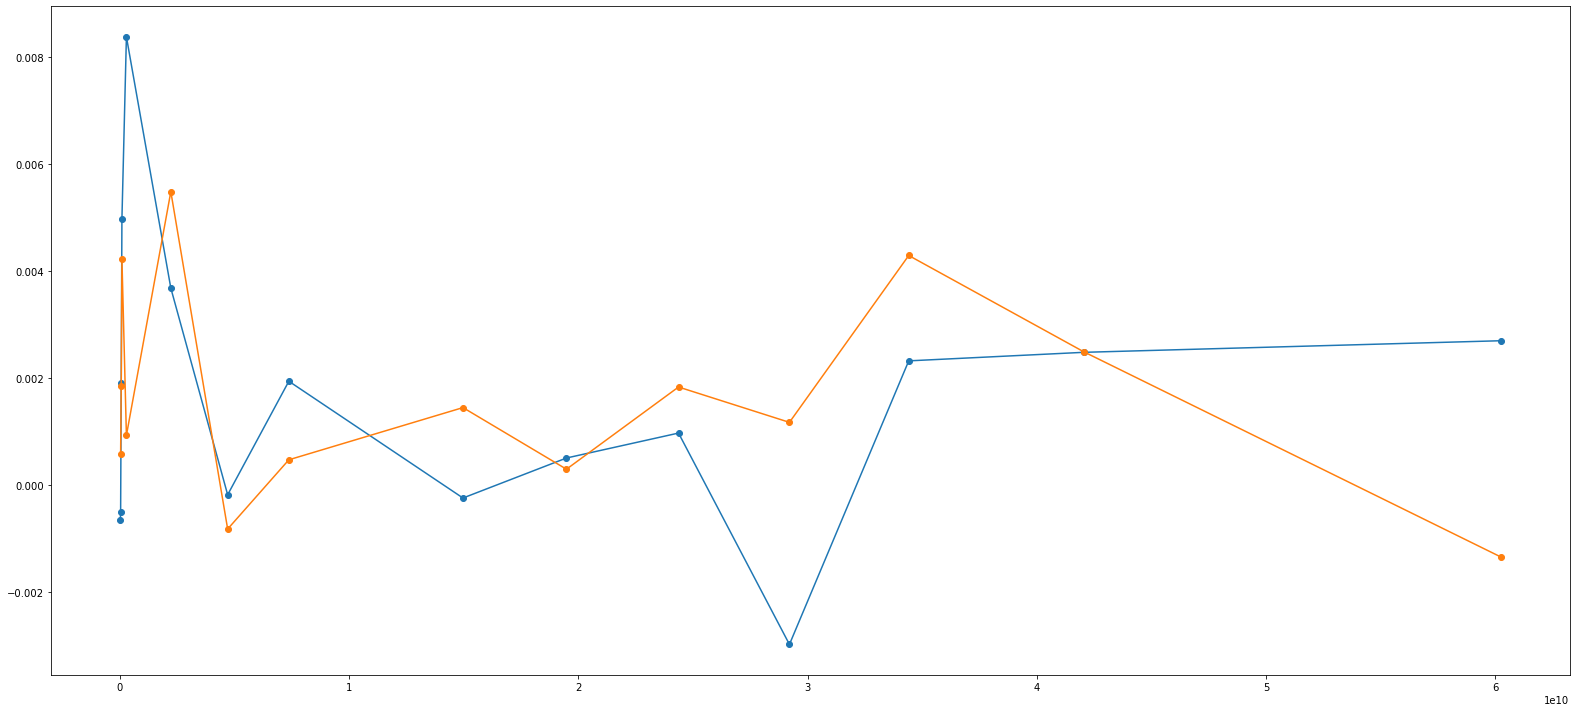

In [102]:
fig = plt.figure(figsize=(22,10))
# plt.style.use('bmh')
layout = (1,1)
volume_returns_ax = plt.subplot2grid(layout, (0,0), colspan=2)

_ = volume_returns_ax.plot(df_volume_quantiles['volume', 'median'], df_volume_quantiles['BTC-USD_pct_returns', 'median'], marker='o', label='Median')
_ = volume_returns_ax.plot(df_volume_quantiles['volume', 'median'], df_volume_quantiles['BTC-USD_pct_returns', 'w_avg'], marker='o', label='W Avg')

plt.tight_layout()

In [104]:
df_volatility_10_quantiles

adjclose_volatility_10            \
                                                         count    median   
BTC-USD_adjclose_volatility_10_quantile                                    
(0.00115, 0.0131]                                          336  0.010415   
(0.0131, 0.0188]                                           335  0.016338   
(0.0188, 0.0229]                                           335  0.020648   
(0.0229, 0.0274]                                           335  0.024964   
(0.0274, 0.0323]                                           336  0.029983   
(0.0323, 0.0374]                                           335  0.034895   
(0.0374, 0.0435]                                           335  0.040117   
(0.0435, 0.0564]                                           335  0.049264   
(0.0564, 0.148]                                            336  0.066581   

                                                  BTC-USD_pct_returns  \
                                             mean              median   
BTC-USD_adjclose_volatility_10_quantile                                 
(0.00115, 0.0131]                        0.009927            0.001444   
(0.0131, 0.0188]                         0.016117            0.001919   
(0.0188, 0.0229]                         0.020770            0.001778   
(0.0229, 0.0274]                         0.025078            0.000735   
(0.0274, 0.0323]                         0.029862            0.001467   
(0.0323, 0.0374]                         0.034882            0.001295   
(0.0374, 0.0435]                         0.040077            0.005273   
(0.0435, 0.0564]                         0.049625            0.003352   
(0.0564, 0.148]                          0.072456            0.000261   

                                                             
                                             mean     w_avg  
BTC-USD_adjclose_volatility_10_quantile                      
(0.00115, 0.0131]                        0.001584  0.001035  
(0.0131, 0.0188]                         0.002251  0.001395  
(0.0188, 0.0229]                         0.001604  0.000357  
(0.0229, 0.0274]                         0.002177  0.001395  
(0.0274, 0.0323]                         0.001893  0.002770  
(0.0323, 0.0374]                         0.001454  0.000193  
(0.0374, 0.0435]                         0.004666  0.003446  
(0.0435, 0.0564]                        -0.001083 -0.005287  
(0.0564, 0.148]                          0.003192  0.006033

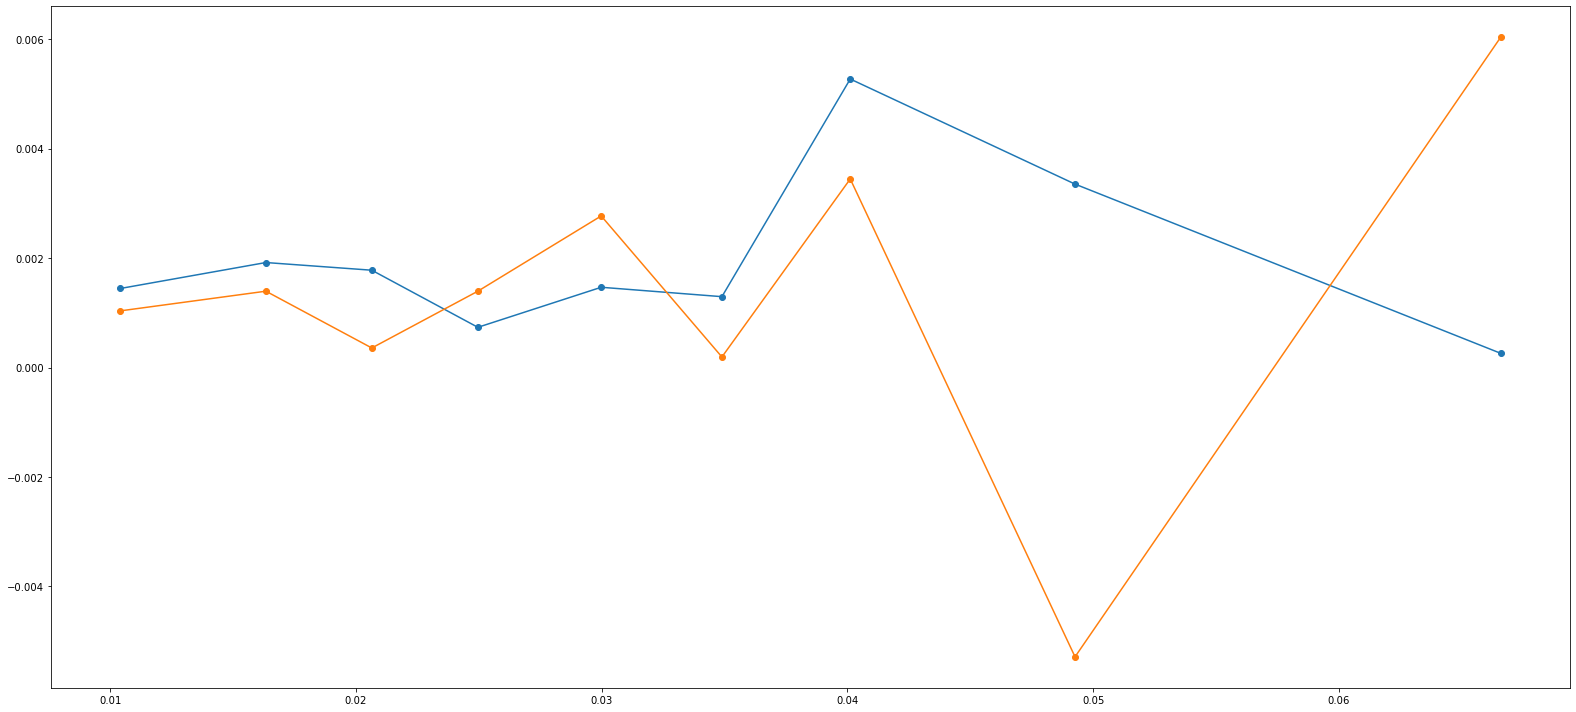

In [105]:
fig = plt.figure(figsize=(22,10))
# plt.style.use('bmh')
layout = (1,1)
volume_returns_ax = plt.subplot2grid(layout, (0,0), colspan=2)

_ = volume_returns_ax.plot(df_volatility_10_quantiles['adjclose_volatility_10', 'median'], df_volatility_10_quantiles['BTC-USD_pct_returns', 'median'], marker='o', label='Median')
_ = volume_returns_ax.plot(df_volatility_10_quantiles['adjclose_volatility_10', 'median'], df_volatility_10_quantiles['BTC-USD_pct_returns', 'w_avg'], marker='o', label='W Avg')

plt.tight_layout()

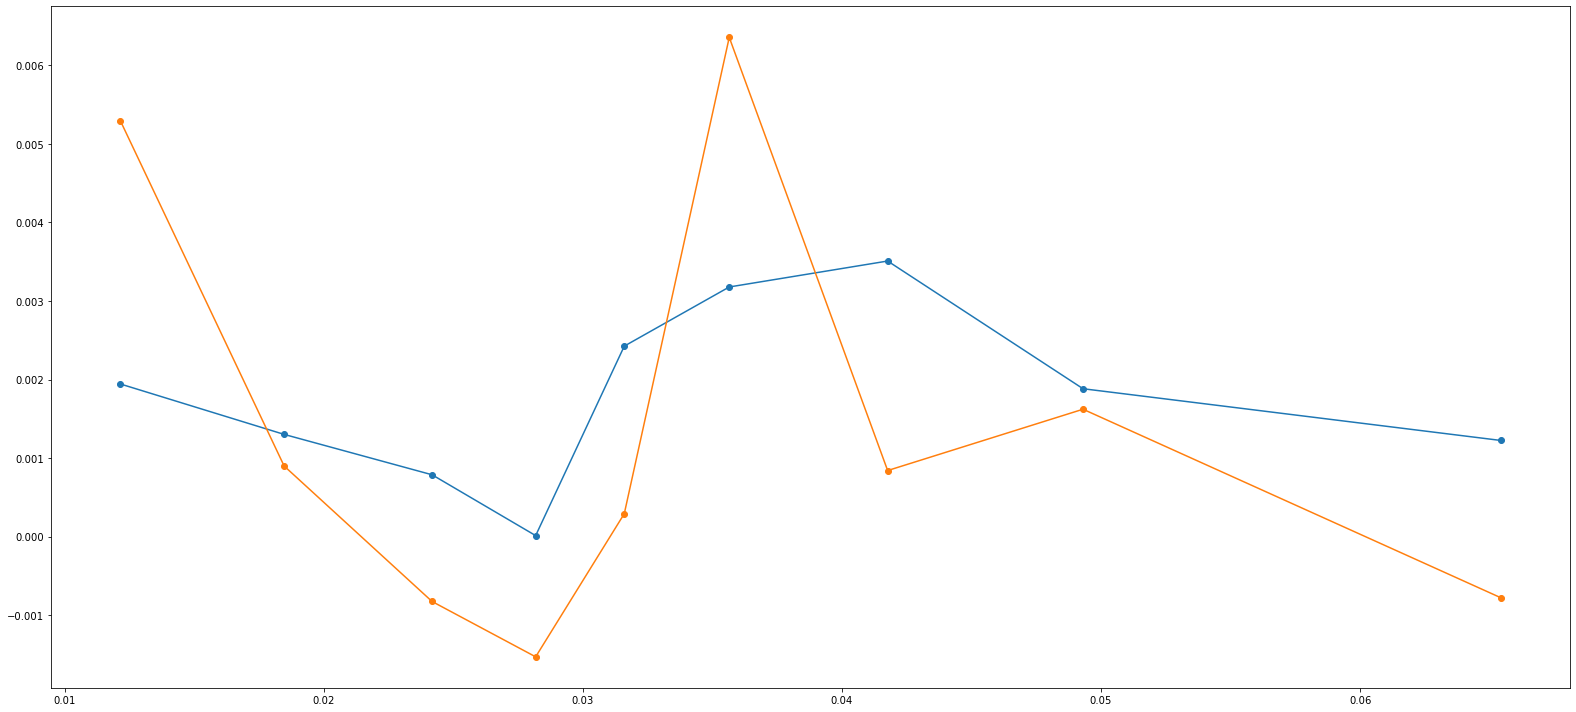

In [107]:
fig = plt.figure(figsize=(22,10))
# plt.style.use('bmh')
layout = (1,1)
volume_returns_ax = plt.subplot2grid(layout, (0,0), colspan=2)

_ = volume_returns_ax.plot(df_volatility_20_quantiles['adjclose_volatility_20', 'median'], df_volatility_20_quantiles['BTC-USD_pct_returns', 'median'], marker='o', label='Median')
_ = volume_returns_ax.plot(df_volatility_20_quantiles['adjclose_volatility_20', 'median'], df_volatility_20_quantiles['BTC-USD_pct_returns', 'w_avg'], marker='o', label='W Avg')

plt.tight_layout()

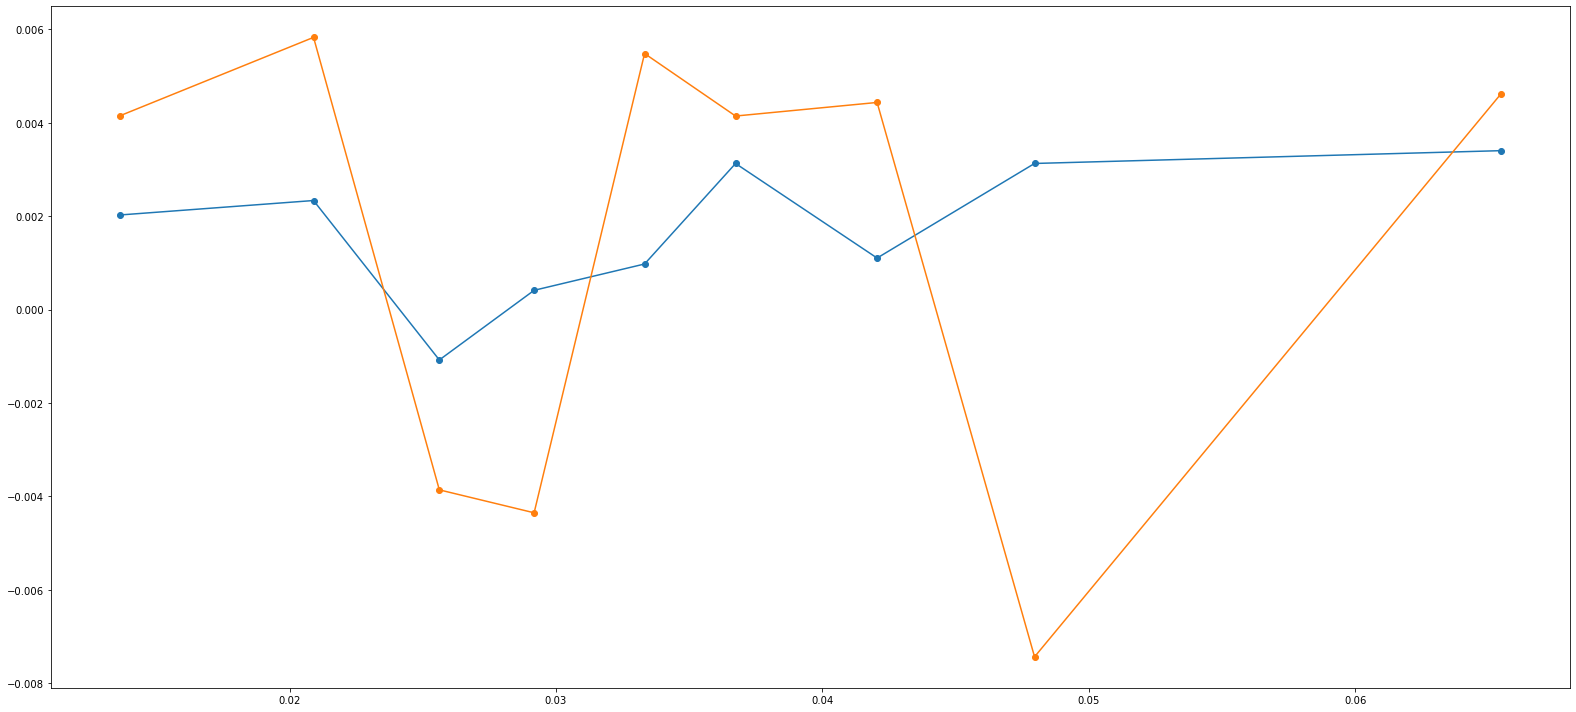

In [108]:
fig = plt.figure(figsize=(22,10))
# plt.style.use('bmh')
layout = (1,1)
volume_returns_ax = plt.subplot2grid(layout, (0,0), colspan=2)

_ = volume_returns_ax.plot(df_volatility_30_quantiles['adjclose_volatility_30', 'median'], df_volatility_30_quantiles['BTC-USD_pct_returns', 'median'], marker='o', label='Median')
_ = volume_returns_ax.plot(df_volatility_30_quantiles['adjclose_volatility_30', 'median'], df_volatility_30_quantiles['BTC-USD_pct_returns', 'w_avg'], marker='o', label='W Avg')

plt.tight_layout()

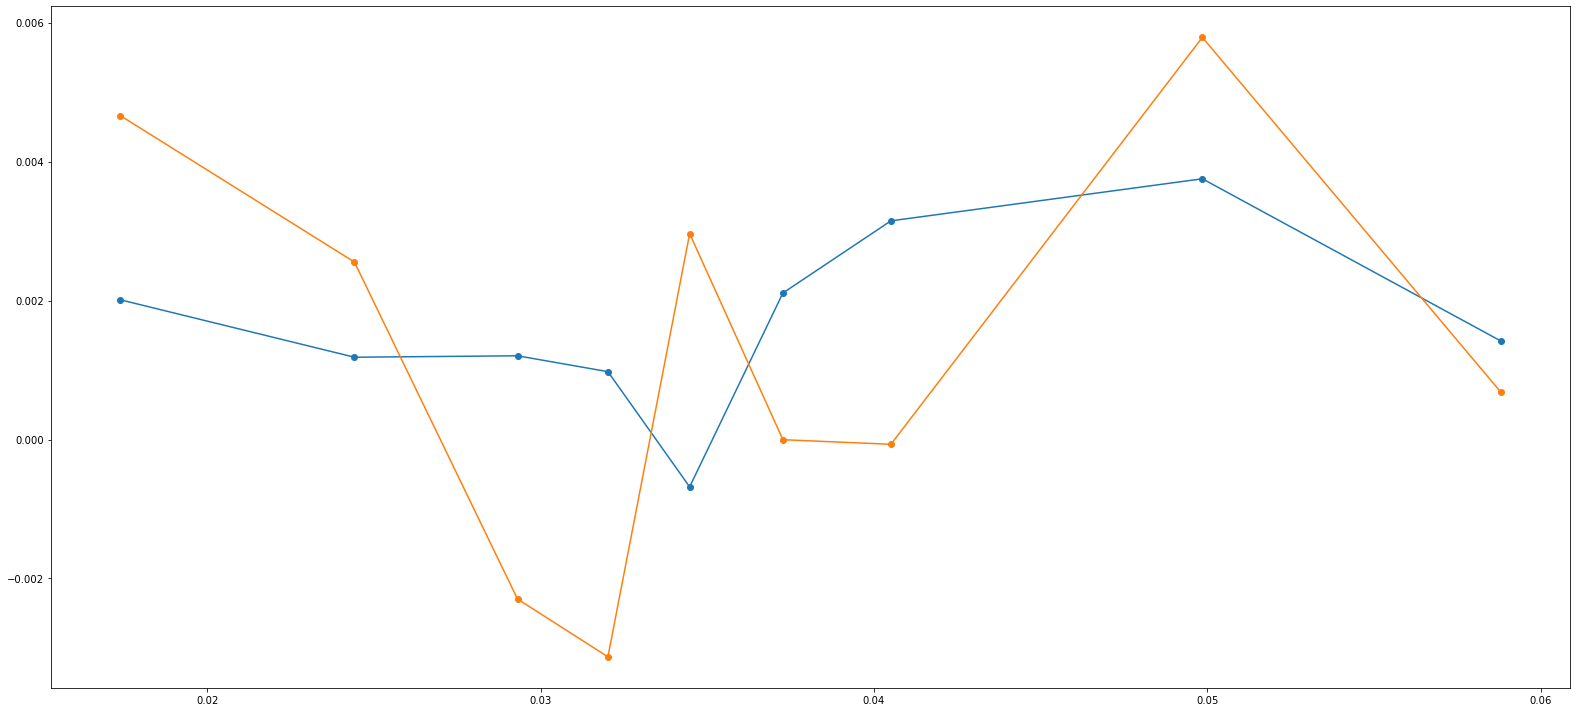

In [109]:
fig = plt.figure(figsize=(22,10))
# plt.style.use('bmh')
layout = (1,1)
volume_returns_ax = plt.subplot2grid(layout, (0,0), colspan=2)

_ = volume_returns_ax.plot(df_volatility_60_quantiles['adjclose_volatility_60', 'median'], df_volatility_60_quantiles['BTC-USD_pct_returns', 'median'], marker='o', label='Median')
_ = volume_returns_ax.plot(df_volatility_60_quantiles['adjclose_volatility_60', 'median'], df_volatility_60_quantiles['BTC-USD_pct_returns', 'w_avg'], marker='o', label='W Avg')

plt.tight_layout()

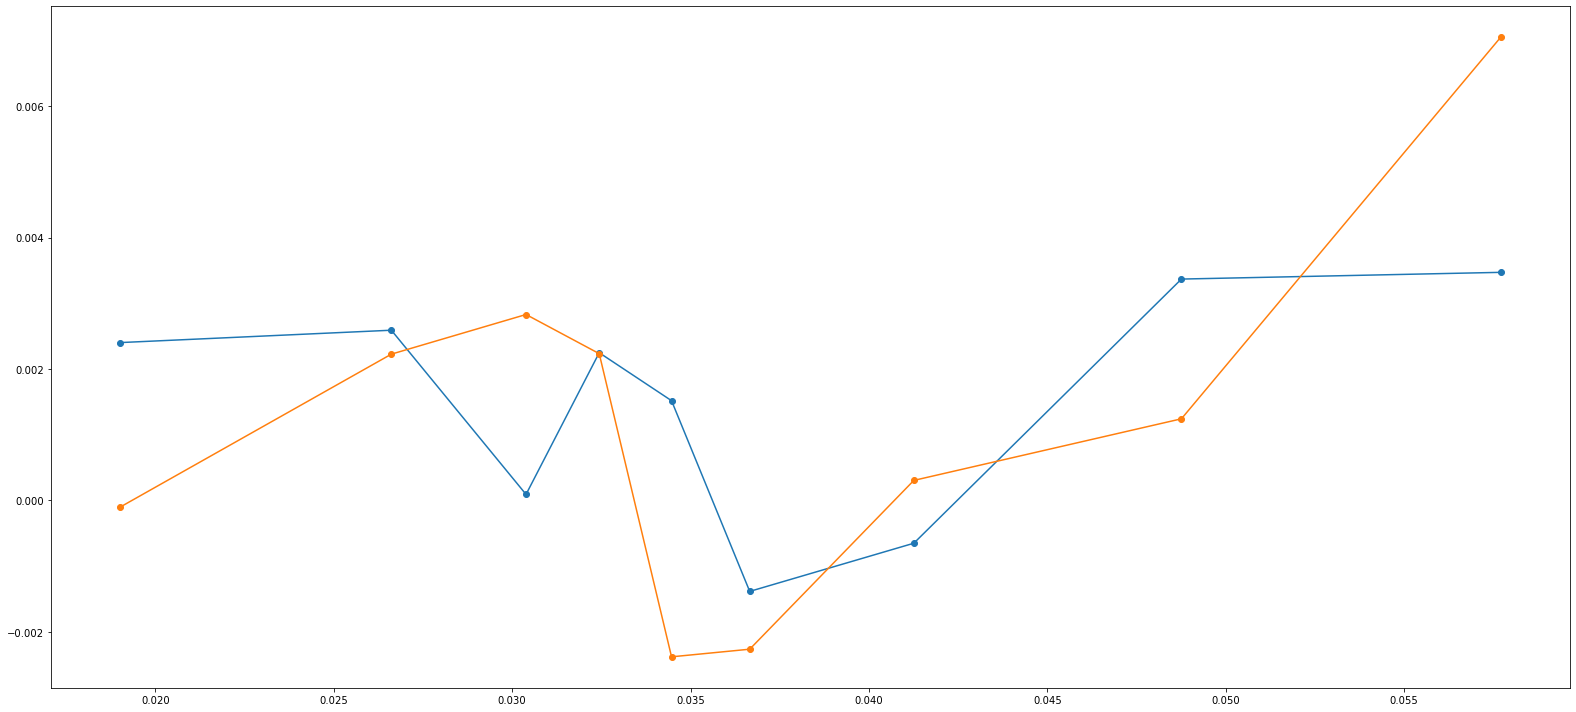

In [110]:
fig = plt.figure(figsize=(22,10))
# plt.style.use('bmh')
layout = (1,1)
volume_returns_ax = plt.subplot2grid(layout, (0,0), colspan=2)

_ = volume_returns_ax.plot(df_volatility_90_quantiles['adjclose_volatility_90', 'median'], df_volatility_90_quantiles['BTC-USD_pct_returns', 'median'], marker='o', label='Median')
_ = volume_returns_ax.plot(df_volatility_90_quantiles['adjclose_volatility_90', 'median'], df_volatility_90_quantiles['BTC-USD_pct_returns', 'w_avg'], marker='o', label='W Avg')

plt.tight_layout()